# Animals classification

In deze notebook wordt er geprobeerd om verschillende images van dieren te voorspellen. De dieren komen vanuit de cifar-10 dataset. Dit wordt gedaan met behulp van CNN.

<span style="color:red">! note:</span> de images zijn gedownload. Er wordt verwacht dat je een directory hebt aangemaakt met deze images in verschillende folders.

### Importeer libraries

In [1]:
import os
import time

import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import to_categorical

from keras import backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

De volgende dieren worden gebruikt in deze file. Zorg er dus voor dat de images in verschillende folders zijn.

In [2]:
BASE_PATH = './Animals-10/'
animals = []

for dirname, _, filenames in os.walk(BASE_PATH):
    if dirname != BASE_PATH:
        animals.append(dirname.replace(BASE_PATH, ''))

animals

['cat', 'butterfly', 'dog', 'sheep', 'horse']

Bekijk welke devices beschikbaar zijn

In [3]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Maak de features en labels aan

In [4]:
BASE_PATH = './Animals-10/'

X = [] # features
y = [] # labels

animals = ['butterfly', 'cat', 'dog', 'horse', 'sheep'] # alle dieren in de directory

for subdir, _, files in os.walk(BASE_PATH):
    for file in files:
        filepath = subdir + os.sep + file

        if filepath.endswith(".jpg"): # er zijn jpeg en jpg afbeeldingen. Ik heb alleen de jpgs gepakt
            try:
                img = plt.imread(filepath)

                img = cv.resize(img, dsize=(128, 128)) # elke afbeelding even groot maken (100*100)
                #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # haal rgb weg
                # normaliseer
                img = img.astype(np.float32)
                img /= 255.0
                
                X.append(img)
                y.append(animals.index(file.split()[0]))
            except:
                pass

one-hot-encoding

In [5]:
y = to_categorical(y)

voorbeeld van de encoding

[0. 1. 0. 0. 0.]


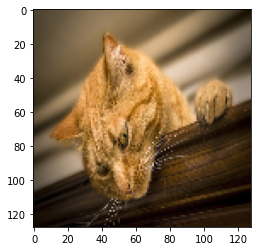

In [6]:
print(y[0])
plt.imshow(X[1])

verander de X en y naar numpy arrays

In [7]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1238, 128, 128, 3), (1238, 5))

split data in train en test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train.shape, X_test.shape

((990, 128, 128, 3), (248, 128, 128, 3))

[array([0., 0., 0., 0., 1.], dtype=float32)]


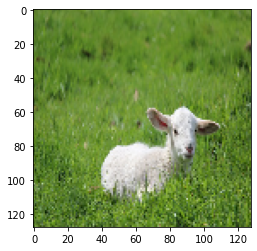

In [10]:
print([y_train[12]])
plt.imshow(X_train[12])

### Model

Info over layers:

Conv2d:
- Creert een kernel die helpt om tensor outputs te krijgen. 
- Padding same wordt aangevuld met nullen. Bij Valid gaat er informatie weg.

MaxPooling2D:
- Reduceert dimenties. E.g. van 32*32 naar 16*16
- strides: stapsgrootte

In [11]:
def create_model():
    """Maakt en teturned een CNN model"""
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu', input_shape=(128,128, 3)))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    model.add(Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2,strides=2))

    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')
    
    return model

def show_accuracy_results(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(title)

    ax1.set_title('Accuracy')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')

    ax2.set_title('model loss')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')

    plt.tight_layout()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##### CPU

In [11]:
cpu_model = create_model()
cpu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dropout (Dropout)           (None, 61504)             0

In [12]:
with tf.device("/cpu:0"):
    start = time.time()
    cpu_history = cpu_model.fit(X_train,y_train,epochs=10,batch_size = 32, validation_split=0.1)

    end = time.time()
    cpu_train_time = end - start
    print('\ntrain time: ', cpu_train_time)  

Train on 891 samples, validate on 99 samples
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/10


2022-05-15 14:25:46.367574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-15 14:25:46.367812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-15 14:25:46.382298: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-15 14:25:46.382698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 14:25:46.405288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 14:25:46.435024: I tensorflow/core/grappler/o

891/891 [==============================] - 5s 5ms/sample - loss: 1.1052 - accuracy: 0.4624 - val_loss: 0.8282 - val_accuracy: 0.6869


/Users/aliozcan/miniforge3/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-05-15 14:25:51.093124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.6864 - accuracy: 0.7059 - val_loss: 0.7470 - val_accuracy: 0.7172
Epoch 3/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.6243 - accuracy: 0.7565 - val_loss: 0.7733 - val_accuracy: 0.7172
Epoch 4/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.5197 - accuracy: 0.7980 - val_loss: 0.7241 - val_accuracy: 0.7273
Epoch 5/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.4677 - accuracy: 0.8171 - val_loss: 0.8137 - val_accuracy: 0.7374
Epoch 6/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.4271 - accuracy: 0.8485 - val_loss: 0.7211 - val_accuracy: 0.7475
Epoch 7/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.3680 - accuracy: 0.8878 - val_loss: 0.7218 - val_accuracy: 0.7677
Epoch 8/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.3267 - accuracy: 0.8855 - val_loss: 0.6302 - val_accuracy:

In [13]:
start = time.time()
loss, acc = cpu_model.evaluate(X_test,
                         y_test)
end = time.time()
cpu_test_time = end - start
print('test time: ', cpu_test_time)
print('acc: ', acc)

test time:  0.3886551856994629
acc:  0.7862903


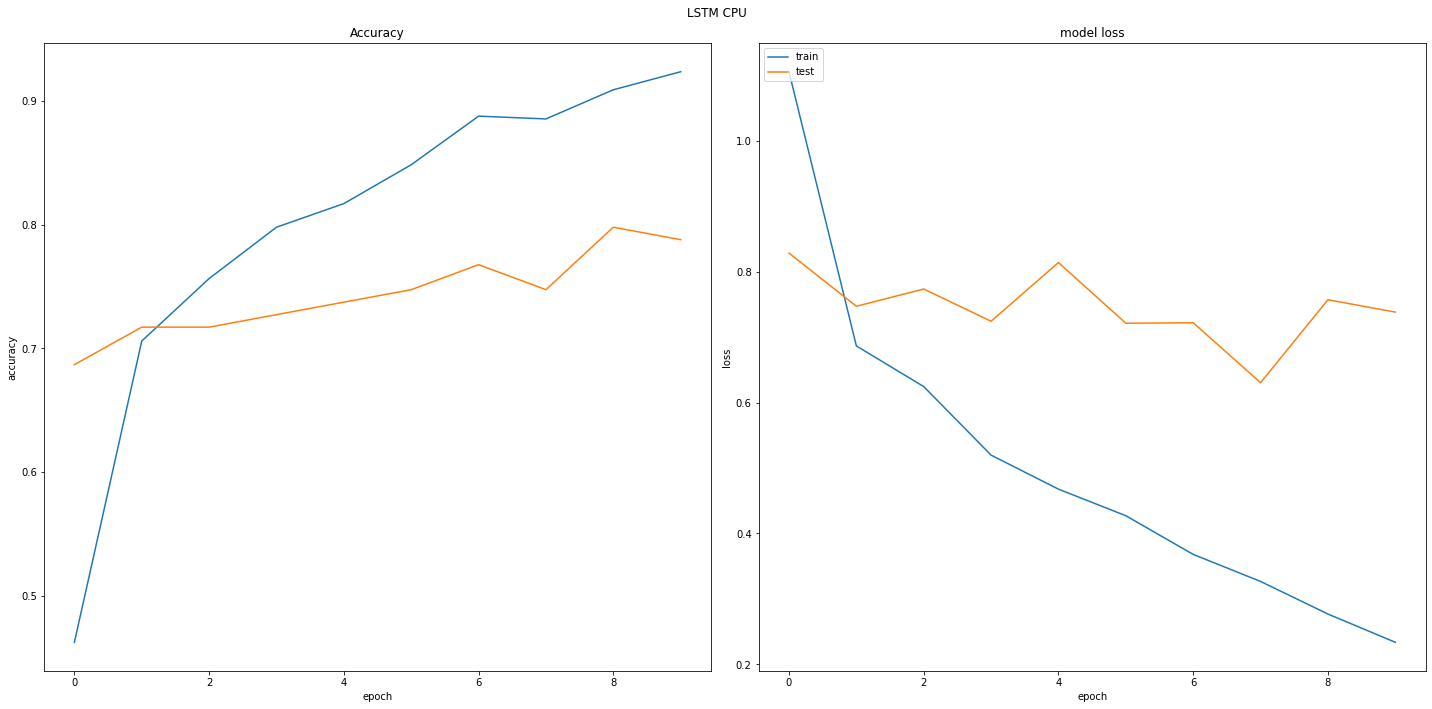

In [14]:
show_accuracy_results(cpu_history, 'LSTM CPU')

<p style="color:#F64C72">Insights</p>

- Nog steeds ietjes overfit
- Loss aan het eind is wel veel.

##### GPU

In [15]:
gpu_model = create_model()
gpu_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 63, 63, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dropout_1 (Dropout)         (None, 61504)            

In [16]:
with tf.device("/gpu:0"):
    start = time.time()
    gpu_history = gpu_model.fit(X_train,y_train,epochs=10,batch_size=32, validation_split=0.1)

    end = time.time()
    gpu_train_time = end - start
    print('\ntrain time: ', gpu_train_time) 

Train on 891 samples, validate on 99 samples
Epoch 1/10


2022-05-15 14:27:04.242447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 14:27:04.269433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 14:27:04.340885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 14:27:04.348482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 3s 3ms/sample - loss: 1.1305 - accuracy: 0.4837 - val_loss: 0.8253 - val_accuracy: 0.6869
Epoch 2/10


/Users/aliozcan/miniforge3/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-05-15 14:27:06.787868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 2s 2ms/sample - loss: 0.7028 - accuracy: 0.7082 - val_loss: 0.7832 - val_accuracy: 0.6869
Epoch 3/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.6227 - accuracy: 0.7531 - val_loss: 0.7607 - val_accuracy: 0.7172
Epoch 4/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.5468 - accuracy: 0.7901 - val_loss: 0.7248 - val_accuracy: 0.7071
Epoch 5/10
891/891 [==============================] - 2s 3ms/sample - loss: 0.5069 - accuracy: 0.8137 - val_loss: 0.7000 - val_accuracy: 0.7576
Epoch 6/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.4288 - accuracy: 0.8316 - val_loss: 0.7121 - val_accuracy: 0.7374
Epoch 7/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.3732 - accuracy: 0.8664 - val_loss: 0.8166 - val_accuracy: 0.7576
Epoch 8/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.3481 - accuracy: 0.8810 - val_loss: 0.7150 - val_accuracy: 0.7778
Epo

In [17]:
start = time.time()
loss, acc = gpu_model.evaluate(X_test,y_test)
end = time.time()
gpu_test_time = end - start
print('test time: ', gpu_test_time)
print('acc: ', acc)

test time:  0.3024017810821533
acc:  0.79032254


**Insigts**

- Sneller dan CPU
- Ietjes hogere accuracy dan CPU

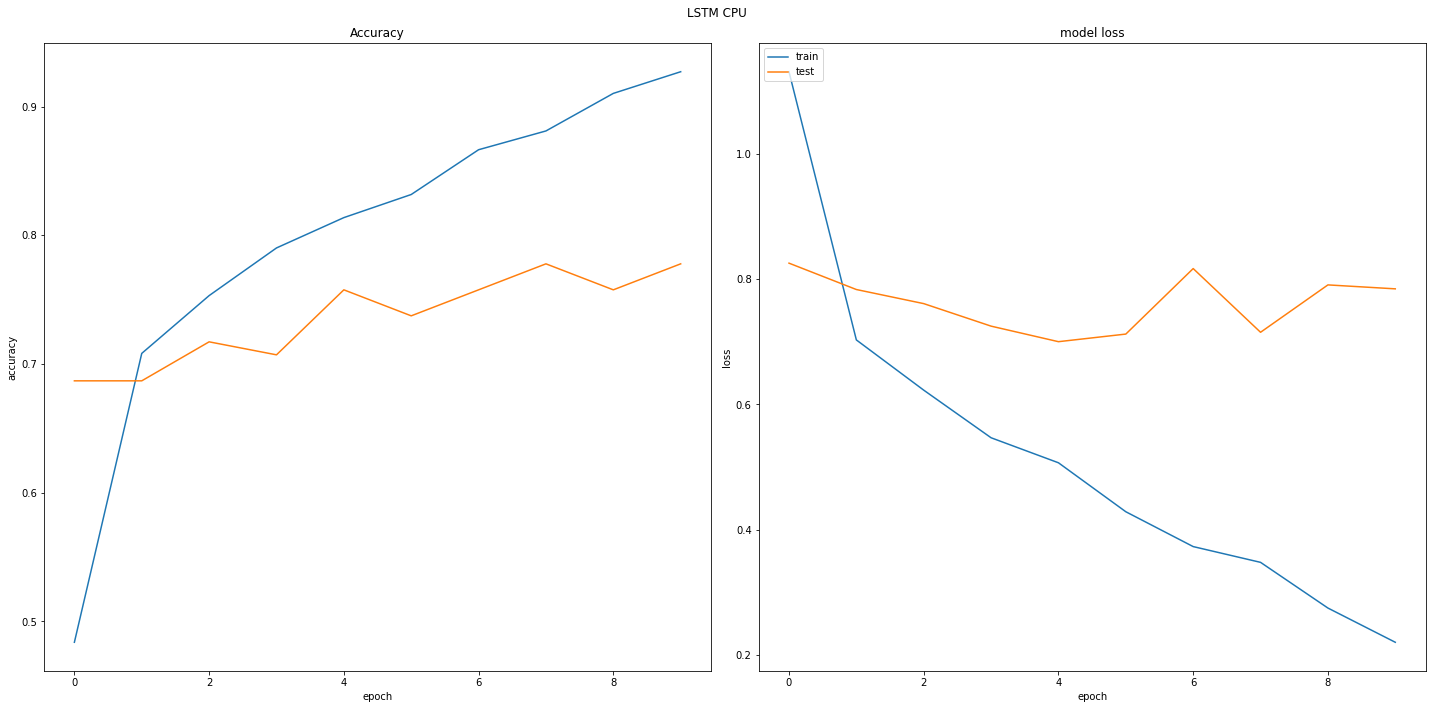

In [18]:
show_accuracy_results(gpu_history, 'LSTM CPU')

<p style="color:#F64C72">Insights</p>

- Nog steeds ietjes overfit
- Loss aan het eind is wel veel. Wel minder dan CPU.

##### Dense Netwerk

In [12]:
X_train.shape

(990, 128, 128, 3)

(128, 128)


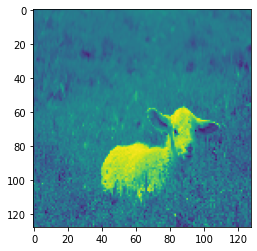

In [13]:
test_image = cv.cvtColor(X_train[12], cv.COLOR_BGR2GRAY)
print(test_image.shape)
plt.imshow(test_image)

In [14]:
X_train_grayscaled = []
X_test_grayscaled = []

for img in X_train:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_train_grayscaled.append(gray_scaled_img)

for img in X_test:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_test_grayscaled.append(gray_scaled_img)

X_train_grayscaled = np.array(X_train_grayscaled)
X_test_grayscaled = np.array(X_test_grayscaled)

In [15]:
X_train_grayscaled.shape, X_test_grayscaled.shape

((990, 128, 128), (248, 128, 128))

In [16]:
X_train_reshaped = X_train_grayscaled.reshape(990, 128*128)
X_test_reshaped = X_test_grayscaled.reshape(248, 128*128)

In [17]:
X_train_reshaped.shape, X_test_reshaped.shape

((990, 16384), (248, 16384))

In [28]:
model = Sequential()

model.add(Dense(128,activation = 'relu',input_shape=(128*128,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5,activation = 'softmax'))

model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')

In [29]:
start = time.time()
history = model.fit(X_train_reshaped,y_train,epochs=15,batch_size = 16, validation_split=0.1)

end = time.time()
train_time = end - start
print('train time: ', train_time)

Train on 891 samples, validate on 99 samples
Epoch 1/15
 16/891 [..............................] - ETA: 5s - loss: 1.4601 - accuracy: 0.4375

2022-05-15 19:07:24.571469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 19:07:24.605007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 19:07:24.659195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-15 19:07:24.667599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 1s 1ms/sample - loss: 1.9656 - accuracy: 0.3850 - val_loss: 1.1356 - val_accuracy: 0.4545
Epoch 2/15
112/891 [==>...........................] - ETA: 0s - loss: 1.0389 - accuracy: 0.5089

2022-05-15 19:07:25.573557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 1s 675us/sample - loss: 1.3939 - accuracy: 0.4141 - val_loss: 1.3669 - val_accuracy: 0.4343
Epoch 3/15
891/891 [==============================] - 1s 672us/sample - loss: 1.2258 - accuracy: 0.4400 - val_loss: 1.4566 - val_accuracy: 0.3737
Epoch 4/15
891/891 [==============================] - 1s 660us/sample - loss: 1.0828 - accuracy: 0.5017 - val_loss: 1.1894 - val_accuracy: 0.4040
Epoch 5/15
891/891 [==============================] - 1s 674us/sample - loss: 1.1010 - accuracy: 0.5095 - val_loss: 1.3412 - val_accuracy: 0.4141
Epoch 6/15
891/891 [==============================] - 1s 660us/sample - loss: 1.1517 - accuracy: 0.4994 - val_loss: 1.7239 - val_accuracy: 0.3737
Epoch 7/15
891/891 [==============================] - 1s 667us/sample - loss: 0.9558 - accuracy: 0.5578 - val_loss: 1.1526 - val_accuracy: 0.4444
Epoch 8/15
891/891 [==============================] - 1s 685us/sample - loss: 0.9626 - accuracy: 0.5668 - val_loss: 1.1694 - val_accura

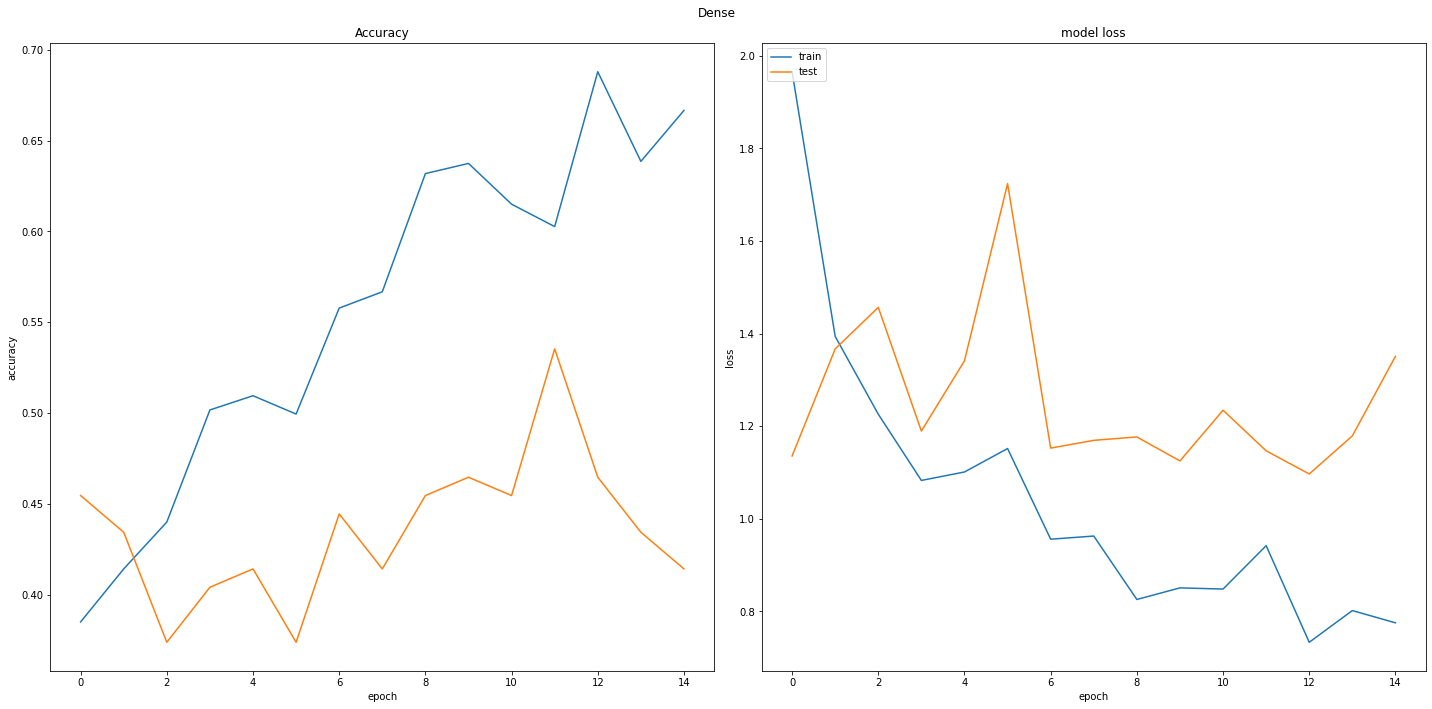

In [30]:
show_accuracy_results(history, 'Dense')

#### KNeighborsClassifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

knn.fit(X_train_reshaped, y_train)

KNeighborsClassifier(weights='distance')

In [19]:
pred = knn.predict(X_test_reshaped)
accuracy_score(y_test, pred)

0.41935483870967744

#### Autoencoders

Het doel is om noise uit images weg te krijgen. Dit wordt gedaan m.b.v. autoencoders.

In [31]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [32]:
train_data_noisy = add_noise_and_clip_data(X_train)
test_data_noisy = add_noise_and_clip_data(X_test)

In [33]:
X_train.shape

(990, 128, 128, 3)

In [34]:
train_data_noisy.shape

(990, 128, 128, 3)

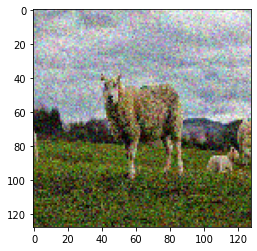

In [35]:
plt.imshow(train_data_noisy[13])

In [195]:
#Encoder
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))

Upsampling: verdubbelt dimensies

Conv2DTranspose: inverse van Conv2D

In [196]:
# Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))

model.add(Conv2D(3, (3,3), activation='relu', padding='same'))

In [197]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 16, 16, 16)      

In [199]:
# Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [200]:
model.fit(train_data_noisy, X_train, epochs=30, batch_size=64, validation_split=0.1, shuffle=True)

Train on 891 samples, validate on 99 samples


2022-05-16 00:11:02.741423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 00:11:02.916957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2022-05-16 00:11:03.064155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-16 00:11:03.105038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.4732

2022-05-16 00:11:08.853743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 6s 7ms/sample - loss: 0.1111 - accuracy: 0.4732 - val_loss: 0.0488 - val_accuracy: 0.3143
Epoch 2/30
891/891 [==============================] - 5s 6ms/sample - loss: 0.0403 - accuracy: 0.4745 - val_loss: 0.0330 - val_accuracy: 0.4706
Epoch 3/30
891/891 [==============================] - 5s 5ms/sample - loss: 0.0297 - accuracy: 0.4380 - val_loss: 0.0261 - val_accuracy: 0.5330
Epoch 4/30
891/891 [==============================] - 5s 5ms/sample - loss: 0.0248 - accuracy: 0.5334 - val_loss: 0.0227 - val_accuracy: 0.5052
Epoch 5/30
891/891 [==============================] - 4s 5ms/sample - loss: 0.0214 - accuracy: 0.5386 - val_loss: 0.0196 - val_accuracy: 0.5328
Epoch 6/30
891/891 [==============================] - 4s 5ms/sample - loss: 0.0190 - accuracy: 0.5399 - val_loss: 0.0184 - val_accuracy: 0.5541
Epoch 7/30
891/891 [==============================] - 4s 5ms/sample - loss: 0.0180 - accuracy: 0.5478 - val_loss: 0.0176 - val_accuracy: 0.5574
Epo

In [201]:
pred = model.predict(test_data_noisy[:5])

2022-05-16 00:13:28.262860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


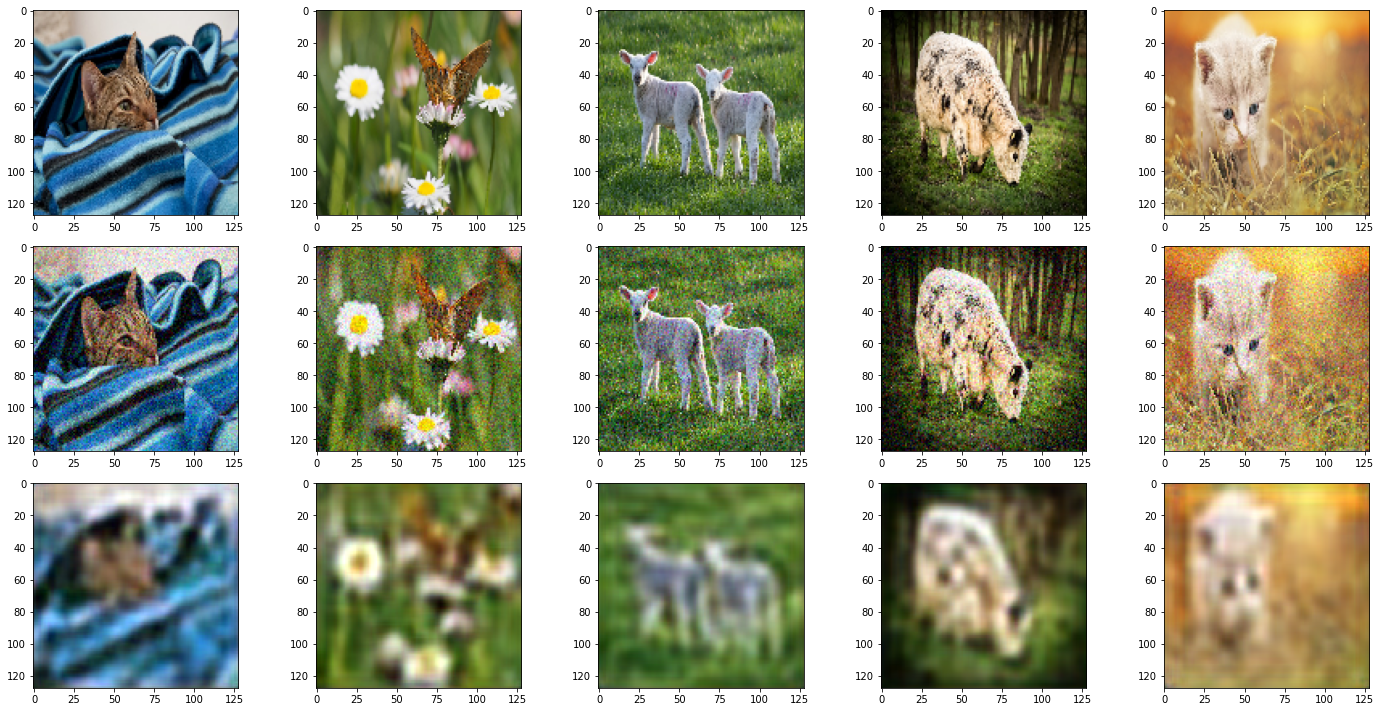

In [202]:
f, ax = plt.subplots(3, 5)
f.set_size_inches(20,10)

for i in range(5):
    ax[0][i].imshow(X_test[i])
    ax[1][i].imshow(test_data_noisy[i])
    ax[2][i].imshow(pred[i])

plt.tight_layout()


<p style="color:#F64C72">Insights</p>

- De afbeeldingen zijn niet meer noisy, maar zijn zeker wel wazig.

### Conclusie

DE CNN model doet het veel beter dan een normale Dense neurale netwerk. Dit was ook wel te verwachten. De Dense netwerk is wel heel wat sneller qua trainen. Ook doet het het beter dan de KNN. De knn doet het even als de normale Dense netwerk. Alleen denk ik dat de nn het beter kan doen als we het optimaliseren.

Bij beide modellen is er sprake van overfitting. Misschien kan het handig zijn om nog even te spelen met het aantal neuronen en aantal Conv2D layers. Een percentage is 78 accuracy is niet verkeerd. Toch denk ik dat het beter kan als we de model optimaliseren.

Bij het denoisen is de noise weg, maar het is echt wazig geworden. Waarschijnlijk is het niet goed genoeg getrained om de noise eruit te kunnen halen. Misschien ook wat meer lagen toevoegen om het beter werkend te krijgen. Ik denk niet dat de epochs verhogen helpt, aangezien de accuracy blijft hangen op 75-80%.

GPU geeft wat betere resultaat dan CPU. Bovendien is het ook veel sneller qua trainen. 

### Bronnen

- https://androidkt.com/filters-kernel-size-input-shape-in-conv2d-layer/